# Predicting Cardiac Diseases in Children


## Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from sklearn.preprocessing import StandardScaler
import re

## Read Dataset And Initial Exploration


##### 1.1 Loading the Dataset and Initial Preview

In [2]:
filepath = 'Data/UCMF(5).xls'
df = pd.read_excel(filepath)

## Drop id
df.drop(columns="ID",inplace=True)

print(df.head())

   Peso  Altura   IMC Atendimento        DN IDADE Convenio   PULSOS  \
0   5.0      51  19.0    11/05/06  30/03/06  0.12       GS  Normais   
1   3.5      50  14.0    25/05/05  19/05/05  0.02       GS  Normais   
2   0.0       0   NaN    12/06/01  08/05/05 -4.05     SULA  Normais   
3   8.1      65  19.0    15/10/09  21/04/09   0.5      NaN  Normais   
4  39.5     142  20.0    23/01/09  24/10/99   9.6    Sulam  Normais   

   PA SISTOLICA  PA DIASTOLICA            PPA NORMAL X ANORMAL      B2  \
0           NaN            NaN  Não Calculado          Anormal  Normal   
1           NaN            NaN  Não Calculado          Anormal  Normal   
2           NaN            NaN  Não Calculado          Anormal  Normal   
3           NaN            NaN  Não Calculado          Anormal  Normal   
4          85.0           50.0         Normal          Anormal  Normal   

       SOPRO   FC          HDA 1 HDA2 SEXO                      MOTIVO1  \
0  Sistólico  112     Palpitacao  NaN    M  6 - Suspe

This section loads the original dataset from the Excel file and displays the first rows to inspect the structure, variable names, and obvious data quality issues. The `ID` variable is removed because it is irrelevant for analysis (it does not contain predictive information).

#### 1.2 Dataset Structure and Variable Types


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17873 entries, 0 to 17872
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Peso              17555 non-null  float64
 1   Altura            17873 non-null  int64  
 2   IMC               13146 non-null  float64
 3   Atendimento       16890 non-null  object 
 4   DN                16497 non-null  object 
 5   IDADE             16497 non-null  object 
 6   Convenio          12569 non-null  object 
 7   PULSOS            16675 non-null  object 
 8   PA SISTOLICA      10143 non-null  float64
 9   PA DIASTOLICA     10133 non-null  float64
 10  PPA               17656 non-null  object 
 11  NORMAL X ANORMAL  16705 non-null  object 
 12  B2                16694 non-null  object 
 13  SOPRO             16706 non-null  object 
 14  FC                15832 non-null  object 
 15  HDA 1             12459 non-null  object 
 16  HDA2              652 non-null    object

`df.info()` is used to inspect data types and missing values.
Several variables are incorrectly stored as text (`object`) instead of numeric.
This identifies priority cleaning steps (e.g., type conversion, fixing dates, handling missing values).

#### 1.3 Summary Statistics and Detection of Impossible Values

In [4]:
print(df.describe())

               Peso        Altura           IMC  PA SISTOLICA  PA DIASTOLICA
count  17555.000000  17873.000000  13146.000000  10143.000000   10133.000000
mean      21.163520     83.865216     17.806329    101.314108      62.303661
std       18.061021     56.583610     12.071950     15.510066       8.885555
min      -40.000000      0.000000      0.000000     10.000000       6.000000
25%        6.600000     36.000000     15.000000     90.000000      60.000000
50%       18.000000     99.000000     17.000000    100.000000      60.000000
75%       31.000000    130.000000     19.000000    110.000000      70.000000
max      157.000000    198.000000    848.000000    990.000000     120.000000


`df.describe()` provides basic statistical summaries. Extreme or impossible values (e.g., negative weights, height = 0, systolic pressure = 990) indicate data corruption and highlight the need for extensive cleaning.

#### 1.4 Duplicate Detection

In [5]:
## Check for duplicate rows
print(df.duplicated().sum())
df[df.duplicated()]


1020


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
85,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
130,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
160,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
161,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
174,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17782,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17803,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17833,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17839,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN


We detect 1020 duplicated entries in the dataset, which must be removed to prevent bias and duplicated information in training models.

#### 1.5 Categorical Value Inspection

In [6]:
## Check different 'SEXO' values
df['SEXO'].value_counts(dropna=False)

M                8930
F                6612
Indeterminado    1417
Masculino         584
Feminino          247
masculino          79
NaN                 4
Name: SEXO, dtype: int64

In [7]:
## Check different 'Convenio' values
df['Convenio'].value_counts(dropna=False)

NaN              5304
GS               2763
UR               2287
SB                718
GRUPO             553
                 ... 
caixa               1
CASSI/  PART.       1
Santa Helen         1
CAIXA               1
S.Am                1
Name: Convenio, Length: 440, dtype: int64

In [8]:
## Check different 'NORMAL X ANORMAL' values
df['NORMAL X ANORMAL'].value_counts(dropna=False)

Normal     9991
Anormal    6712
NaN        1168
anormal       1
Normais       1
Name: NORMAL X ANORMAL, dtype: int64

In [9]:
## Check different 'Pulsos' values
df['PULSOS'].value_counts(dropna=False)

Normais                16509
NaN                     1198
Amplos                    57
Outro                     45
Femorais diminuidos       43
Diminuídos                18
NORMAIS                    2
AMPLOS                     1
Name: PULSOS, dtype: int64

In [10]:
## Check different 'PPA' values
df['PPA'].value_counts(dropna=False)

Não Calculado          9081
Normal                 6141
#VALUE!                1496
Pre-Hipertensão PAD     233
NaN                     217
HAS-2 PAS               215
Pre-Hipertensão PAS     193
HAS-1 PAS               153
HAS-1 PAD                86
HAS-2 PAD                58
Name: PPA, dtype: int64

In [11]:
## Check different 'SOPRO' values
df['SOPRO'].value_counts(dropna=False)

ausente                   10727
Sistólico                  4821
NaN                        1167
sistólico                  1090
contínuo                     30
Contínuo                     23
diastólico                   12
Sistolico e diastólico        3
Name: SOPRO, dtype: int64

We inspect unique values in categorical variables to detect inconsistent capitalization, accents, spelling variations, and invalid values. These inconsistencies must be standardized. Example issues include `'masculino'` vs. `'M'` and `'Normal'` vs `'Normais'`, and others.

#### 1.6 Date Variable Cleaning (DN and Atendimento)

In [12]:
today = pd.Timestamp.today()

# Step 1: Identify numeric values (Excel serial numbers)
is_excel_serial = df['DN'].apply(lambda x: isinstance(x, (int, float)))

# Step 2: Convert Excel serial numbers to datetime
df.loc[is_excel_serial, 'DN'] = pd.to_timedelta(df.loc[is_excel_serial, 'DN'], unit='D') + pd.Timestamp('1899-12-30')

# Step 3: Convert remaining strings to datetime
df['DN'] = pd.to_datetime(df['DN'],format='%d/%m/%y', dayfirst=True, errors='coerce')

# Check for impossible dates
df[df['DN'] > today]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
2803,72.1,172,24.0,07/12/07,2055-03-01,54.76,UG,Normais,120.0,85.0,NaN,Normal,Normal,ausente,76,Dispneia,Palpitacao,M,NaN,NaN
8252,89.0,177,28.0,25/10/06,2065-07-15,42.83,Sulamerica,Normais,120.0,90.0,NaN,Normal,Normal,ausente,80,Palpitacao,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
9501,28.0,122,19.0,21/06/04,2068-04-09,37.56,UR,Normais,90.0,50.0,NaN,Normal,Normal,ausente,102,Assintomático,NaN,F,2 - Check-up,NaN
11450,69.5,164,26.0,31/01/06,2068-07-06,38.99,Sulam,Normais,110.0,70.0,NaN,Normal,Normal,ausente,65,NaN,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
12846,52.5,164,20.0,18/06/08,2040-05-31,70.61,Fusex,Normais,120.0,80.0,NaN,Anormal,Normal,Sistólico,80,Dispneia,NaN,F,NaN,NaN
13175,64.0,155,27.0,16/02/07,2068-02-27,40.44,SA,NaN,NaN,NaN,Não Calculado,NaN,NaN,NaN,NaN,NaN,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
14709,36.0,142,18.0,07/02/06,2036-11-24,71.81,NaN,NaN,NaN,NaN,Não Calculado,NaN,NaN,NaN,NaN,NaN,NaN,F,6 - Suspeita de cardiopatia,6 - Dor precordial
15839,68.0,169,24.0,09/06/09,2064-07-10,46.61,NaN,Normais,120.0,80.0,NaN,Normal,Normal,ausente,72,Assintomático,NaN,F,5 - Parecer cardiológico,NaN
15919,0.0,0,NaN,05/07/04,2051-11-01,54.66,NaN,Normais,120.0,80.0,Não Calculado,Normal,Normal,ausente,NaN,NaN,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
15994,89.0,168,32.0,19/03/08,2055-02-23,55.07,Sul America,Outro,160.0,90.0,NaN,Anormal,Normal,ausente,NaN,Assintomático,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica


In [13]:
# Step 1: Identify numeric values (Excel serial numbers)
is_excel_serial = df['Atendimento'].apply(lambda x: isinstance(x, (int, float)))

# Step 2: Convert Excel serial numbers to datetime
df.loc[is_excel_serial, 'Atendimento'] = pd.to_timedelta(df.loc[is_excel_serial, 'Atendimento'], unit='D') + pd.Timestamp('1899-12-30')
# Convert to datetime
df['Atendimento'] = pd.to_datetime(df['Atendimento'],format='%d/%m/%y', dayfirst=True, errors='coerce')

# Check for impossible dates
df[df['Atendimento'] > today]

,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
14972,47.0,0,NaN,2066-08-22,1994-11-14,-29.29,GS,Normais,120.0,70.0,Não Calculado,Normal,Normal,ausente,NaN,NaN,NaN,M,6 - Suspeita de cardiopatia,6 - HAS/dislipidemia/obesidade


Dates appear in mixed formats (Excel serials and dd/mm/yy strings). This section converts all entries to proper datetime format and identifies invalid or future dates, which must be removed.

#### 1.7 Detection of Physiologically Impossible Values

To ensure data quality and avoid training predictive models on corrupted or clinically invalid values, we applied pediatric medical reference ranges to identify and remove **impossible** or **non-physiological** entries. These thresholds were chosen based on standard growth charts, pediatric vital sign tables, and cardiovascular norms for children aged 0–19 years, which is the age group defined for this dataset.

In [14]:
## Check Impossible values for age
df['IDADE'] = pd.to_numeric(df['IDADE'], errors='coerce')
df[(df['IDADE'] < 2) | (df['IDADE'] > 19)]

,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
0,5.0,51,19.0,2006-05-11,2006-03-30,0.12,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,112,Palpitacao,NaN,M,6 - Suspeita de cardiopatia,6 - Palpitação/taquicardia/arritmia
1,3.5,50,14.0,2005-05-25,2005-05-19,0.02,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,128,Dispneia,NaN,M,6 - Suspeita de cardiopatia,6 - Dispnéia
2,0.0,0,NaN,2001-06-12,2005-05-08,-4.05,SULA,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
3,8.1,65,19.0,2009-10-15,2009-04-21,0.50,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,92,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
8,8.0,61,21.0,2006-06-19,2006-03-20,0.26,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,ausente,120,Assintomático,NaN,M,5 - Parecer cardiológico,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17866,9.5,75,17.0,2008-10-13,2007-09-18,1.11,Particular,Normais,NaN,NaN,Não Calculado,Normal,Normal,Sistólico,120,Assintomático,NaN,Feminino,6 - Suspeita de cardiopatia,6 - Sopro
17868,9.5,76,16.0,2006-02-03,2004-12-06,1.20,NaN,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,92,Assintomático,NaN,Masculino,5 - Parecer cardiológico,5 - Cirurgia
17869,12.0,75,21.0,2009-09-25,2008-12-15,0.81,UR,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,90,Assintomático,NaN,Masculino,5 - Parecer cardiológico,5 - Cirurgia
17870,65.0,175,21.0,2007-08-03,1984-02-16,24.34,Medial,Normais,126.0,80.0,Não Calculado,Normal,Normal,ausente,76,Dor precordial,NaN,Feminino,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica


**Age:** Children younger than 2 years were excluded because several clinical variables (blood pressure percentiles, BMI categories, PPA classification) are not standardized for infants. Ages above 19 were also removed, as they fall outside the pediatric population described in the study.

In [15]:
## Check for imppossible values for height , the average height a kid is born is 50 cm
df[(df['Altura'] < 50) | (df['Altura'] > 190)]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
2,0.0,0,NaN,2001-06-12,2005-05-08,-4.05,SULA,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
12,42.0,0,NaN,2009-04-02,1994-04-24,15.50,UR,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,52,Assintomático,NaN,M,2 - Check-up,NaN
15,0.0,0,NaN,2005-03-29,2000-07-31,4.84,GS,Normais,90.0,60.0,Não Calculado,Normal,Normal,ausente,80,NaN,NaN,M,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
20,1.0,0,NaN,2006-11-22,1999-02-01,8.10,GS,Normais,100.0,50.0,Não Calculado,Normal,Outro,ausente,70,NaN,NaN,M,6 - Suspeita de cardiopatia,6 - Dor precordial
21,45.0,0,NaN,2009-08-21,1994-05-10,15.86,NaN,Normais,105.0,70.0,Não Calculado,Normal,Normal,ausente,78,Desmaio/tontura,Palpitacao,M,5 - Parecer cardiológico,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17848,0.0,0,NaN,2009-03-05,NaT,NaN,GRUPO,Normais,NaN,NaN,#VALUE!,Anormal,Normal,Sistólico,120,Assintomático,NaN,Indeterminado,6 - Suspeita de cardiopatia,6 - Sopro
17854,30.0,0,NaN,2006-08-22,NaT,NaN,GS,Normais,140.0,60.0,#VALUE!,NaN,Normal,Sistólico,120,Dispneia,Cianose,Masculino,5 - Parecer cardiológico,Outro
17855,0.0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17862,63.0,0,NaN,2004-04-23,1992-06-17,12.30,SA,Normais,110.0,60.0,Não Calculado,Normal,Normal,ausente,88,Dispneia,NaN,Masculino,NaN,NaN


**Height:** Values below 50 cm are impossible for children above 2 years, and values above 190 cm are extremely rare and likely correspond to data entry errors or corrupted records. These limits help remove physically impossible measures.

In [16]:
## Check for impossible weight values
df[(df['Peso'] < 2) | (df['Peso'] > 100)]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
2,0.0,0,NaN,2001-06-12,2005-05-08,-4.05,SULA,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,88,Assintomático,NaN,M,2 - Check-up,NaN
15,0.0,0,NaN,2005-03-29,2000-07-31,4.84,GS,Normais,90.0,60.0,Não Calculado,Normal,Normal,ausente,80,NaN,NaN,M,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
20,1.0,0,NaN,2006-11-22,1999-02-01,8.10,GS,Normais,100.0,50.0,Não Calculado,Normal,Outro,ausente,70,NaN,NaN,M,6 - Suspeita de cardiopatia,6 - Dor precordial
25,0.0,0,NaN,2005-02-21,1998-01-20,7.36,GS,Normais,105.0,55.0,Não Calculado,Anormal,Normal,sistólico,85,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Atividade física
48,0.0,0,NaN,2009-03-05,2007-11-28,1.32,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,120,Cianose,Dispneia,M,6 - Suspeita de cardiopatia,6 - Sopro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17837,0.0,0,NaN,NaT,NaT,NaN,NaN,Normais,NaN,NaN,#VALUE!,Normal,Normal,ausente,110,Assintomático,NaN,Masculino,6 - Suspeita de cardiopatia,6 - Sopro
17839,0.0,0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,#VALUE!,Normal,NaN,NaN,NaN,NaN,NaN,Indeterminado,NaN,NaN
17843,0.0,0,NaN,2007-11-19,2002-10-15,5.29,Norclínicas,Normais,110.0,70.0,Não Calculado,Anormal,Normal,Sistólico,72,NaN,NaN,Masculino,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
17848,0.0,0,NaN,2009-03-05,NaT,NaN,GRUPO,Normais,NaN,NaN,#VALUE!,Anormal,Normal,Sistólico,120,Assintomático,NaN,Indeterminado,6 - Suspeita de cardiopatia,6 - Sopro


**Weight:** Values under 2 kg or above 100 kg were considered implausible for pediatric patients in this age range and were removed to avoid including corrupted or extreme outlier entries that do not reflect typical pediatric physiology.

In [ ]:
## Check values for IMC, Underweight below 18.5O Morbid Obesity > 40
df[(df['IMC'] < 10) | (df['IMC'] > 60)]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
365,0.0,101,0.0,2009-03-02,2004-11-04,4.49,Real,Normais,90.0,60.0,Normal,Normal,Normal,ausente,80,NaN,NaN,F,2 - Check-up,NaN
382,0.0,62,0.0,2006-03-07,2005-09-15,0.49,SB,NaN,NaN,NaN,Não Calculado,Anormal,Hiperfonética,ausente,100,NaN,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
439,0.0,111,0.0,2008-12-23,2003-12-15,5.21,NaN,Normais,100.0,60.0,Normal,Normal,Normal,ausente,90,Assintomático,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
473,0.0,58,0.0,2008-05-27,2008-05-09,0.05,Medial,Normais,NaN,NaN,Não Calculado,Anormal,Normal,sistólico,120,Assintomático,NaN,M,6 - Suspeita de cardiopatia,6 - Sopro
513,0.0,111,0.0,2008-12-23,2003-12-15,5.21,NaN,Normais,100.0,60.0,Normal,Normal,Normal,ausente,90,Assintomático,NaN,F,5 - Parecer cardiológico,5 - Cirurgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17215,0.0,106,0.0,2003-10-06,1998-10-22,5.14,SA,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,NaN,Assintomático,NaN,Masculino,5 - Parecer cardiológico,5 - Cirurgia
17244,20.0,170,7.0,2006-02-23,2001-07-17,4.78,GS,Normais,NaN,NaN,Não Calculado,Anormal,Normal,Sistólico,92,Assintomático,NaN,Masculino,6 - Suspeita de cardiopatia,6 - Sopro
17366,0.0,92,0.0,NaT,NaT,2.61,NaN,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,96,Assintomático,NaN,Feminino,5 - Parecer cardiológico,NaN
17385,0.0,96,0.0,NaT,2006-01-09,3.99,REAL S.,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,100,Assintomático,NaN,Feminino,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica


**Body Mass Index (IMC):** IMC values below 10 or above 60 fall outside the physiological range observed in children and adolescents and often indicate incorrect data entry (e.g., misplaced decimal points or multiplication errors).

In [18]:
## Check for impossible values of FC , max = 220-age
df['FC'] = pd.to_numeric(df['FC'], errors='coerce')
df[(df['FC'] < 30) | (df['FC'] > 220)]


,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
247,5.9,59,17.0,2008-01-18,2007-09-15,0.36,FUSEX,Normais,NaN,NaN,Não Calculado,Normal,Normal,sistólico,1120.0,Assintomático,NaN,M,6 - Suspeita de cardiopatia,6 - Sopro
899,0.0,0,NaN,2007-08-01,2007-07-23,0.03,GS,NaN,NaN,NaN,Não Calculado,Anormal,Normal,ausente,300.0,Dispneia,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
915,17.7,101,17.0,2006-08-11,2003-01-21,3.69,Grupo,Normais,90.0,60.0,Normal,Anormal,Normal,sistólico,10.0,Assintomático,NaN,F,5 - Parecer cardiológico,NaN
1396,15.6,0,NaN,2008-07-04,2002-11-24,5.82,GRUPO,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,780.0,Dor precordial,NaN,F,5 - Parecer cardiológico,NaN
1505,3.2,47,14.0,2009-06-01,2009-02-26,0.27,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Hiperfonética,sistólico,12.0,Dispneia,NaN,M,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
1586,3.9,50,16.0,2009-03-05,2009-02-04,0.08,NaN,Normais,NaN,NaN,Não Calculado,Anormal,Normal,sistólico,12.0,Assintomático,NaN,M,2 - Check-up,NaN
2986,27.0,116,20.0,2007-12-06,2002-09-23,5.40,NaN,Normais,100.0,60.0,Normal,Anormal,Normal,sistólico,8096.0,Assintomático,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
3057,43.0,0,NaN,2009-07-14,1997-11-23,12.08,NaN,Normais,100.0,60.0,Não Calculado,Normal,Normal,ausente,972.0,Palpitacao,NaN,F,5 - Parecer cardiológico,NaN
3701,56.0,150,25.0,2007-04-23,1995-08-14,12.13,GS,Normais,120.0,80.0,Pre-Hipertensão PAS,Anormal,Normal,sistólico,900.0,Ganho de peso,NaN,M,5 - Parecer cardiológico,5 - Atividade física
5252,13.0,86,18.0,2009-09-04,2007-08-15,2.13,NaN,Normais,NaN,NaN,Não Calculado,Normal,Normal,ausente,801.0,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia


**Cardiac Frequency (FC):** Heart rate values below 30 bpm or above 220 bpm violate known pediatric physiological limits. The upper bound reflects the well-established rule of maximum heart rate ≈ 220 − age, while values below 30 bpm are incompatible with life in non-clinical emergency settings.

In [19]:
## Check impossible values for PA
df[(df['PA SISTOLICA'] < df['PA DIASTOLICA']) |
   (df['PA SISTOLICA'] < 40) |
   (df['PA SISTOLICA'] > 320) |
   (df['PA DIASTOLICA'] < 30) |
   (df['PA DIASTOLICA'] > 200)]

,Peso,Altura,IMC,Atendimento,DN,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,HDA2,SEXO,MOTIVO1,MOTIVO2
3622,35.0,135,19.0,2009-11-23,1998-06-14,11.88,GS,Normais,100.0,6.0,Normal,Anormal,Normal,Sistólico,74.0,Assintomático,NaN,M,2 - Check-up,NaN
8577,20.0,114,15.0,2009-04-07,2002-12-27,6.51,NaN,Normais,10.0,60.0,Normal,Anormal,Normal,Sistólico,110.0,Dispneia,NaN,F,6 - Suspeita de cardiopatia,6 - Sopro
11815,13.9,0,NaN,NaT,NaT,NaN,NaN,Normais,990.0,56.0,#VALUE!,Normal,Normal,ausente,96.0,Assintomático,NaN,F,1 - Cardiopatia já estabelecida,1 - Cardiopatia congenica
13616,17.0,0,NaN,2006-11-26,1996-06-11,10.85,círculo,Normais,90.0,23.0,Não Calculado,Anormal,Hiperfonética,Sistólico,NaN,NaN,NaN,F,NaN,NaN
13845,14.0,95,16.0,2003-09-03,2000-12-16,2.82,SA,Normais,110.0,7.0,HAS-1 PAS,Normal,Normal,ausente,100.0,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Cirurgia
14531,0.0,163,0.0,2007-05-08,1989-06-08,18.59,FUNSEF,Normais,100.0,6.0,NaN,Anormal,Normal,Sistólico,74.0,Assintomático,NaN,M,5 - Parecer cardiológico,5 - Atividade física
17502,44.5,154,19.0,2009-09-03,1997-01-11,13.12,NaN,Normais,700.0,60.0,Não Calculado,Normal,Normal,ausente,80.0,Assintomático,NaN,Masculino,6 - Suspeita de cardiopatia,6 - Sopro


**Blood Pressure:** Systolic blood pressure must always exceed diastolic pressure. Additionally, systolic values below 40 mmHg or above 320 mmHg are physiologically impossible and were filtered out. These thresholds prevent corrupted rows from affecting further analysis.

This cleaning process ensures that analyses are performed on realistic, medically coherent data.

#### 1.8 Missing Value Analysis

In [20]:
## Check Nan in each column
print(df.isna().sum())

Peso                  318
Altura                  0
IMC                  4727
Atendimento          1380
DN                   1685
IDADE                1496
Convenio             5304
PULSOS               1198
PA SISTOLICA         7730
PA DIASTOLICA        7740
PPA                   217
NORMAL X ANORMAL     1168
B2                   1179
SOPRO                1167
FC                   2057
HDA 1                5414
HDA2                17221
SEXO                    4
MOTIVO1              1097
MOTIVO2              4778
dtype: int64


In [21]:
## Check Nan percentage per column
(df.isna().sum() / len(df)) * 100

Peso                 1.779220
Altura               0.000000
IMC                 26.447714
Atendimento          7.721144
DN                   9.427628
IDADE                8.370167
Convenio            29.676048
PULSOS               6.702848
PA SISTOLICA        43.249594
PA DIASTOLICA       43.305545
PPA                  1.214122
NORMAL X ANORMAL     6.534997
B2                   6.596542
SOPRO                6.529402
FC                  11.508980
HDA 1               30.291501
HDA2                96.352039
SEXO                 0.022380
MOTIVO1              6.137750
MOTIVO2             26.733061
dtype: float64

## Data Cleaning


In [22]:
def normalize_text(s):
    if pd.isna(s):
        return s
    # Remove accents
    s = ''.join(
        c for c in unicodedata.normalize('NFD', str(s))
        if unicodedata.category(c) != 'Mn'
    )
    s = s.upper()
    # Replace spaces with underscores
    s = re.sub(r'\s+', '_', s)
    # Remove special characters (keep letters, numbers, and underscores)
    s = re.sub(r'[^A-Z0-9_]', '', s)
    # Remove leading/trailing underscores
    s = s.strip('_')
    return s

In [23]:
# Drop duplicate wor and HDA2 column which had 96% Nan
df = df.drop_duplicates()
df.drop(columns='HDA2',inplace=True)
df.drop(columns='DN',inplace=True)
df.drop(columns='Atendimento',inplace=True)

df['SEXO'] = df['SEXO'].replace({
    'Masculino': 'M',
    'masculino': 'M',
    'Feminino': 'F',
})
df = df[(df['SEXO'] == 'M') | (df['SEXO'] == 'F')]

for col in df.select_dtypes(include=['object', 'category']).columns:
    if col != 'SEXO':
        df[col] = df[col].apply(normalize_text)

# Cleaning rows with impossible Idade values and not child ages
df = df[((df['IDADE'] >= 2) & (df['IDADE'] <= 19)) & (df['IDADE'].notna())]



df.loc[df['Peso'] <= 0, 'Peso'] = np.nan
df.loc[df['Altura'] <= 0, 'Altura'] = np.nan
df.loc[df['IMC'] <= 0, 'IMC'] = np.nan
df = df[(df['IMC'] >= 10) & (df['IMC'] <= 60)]

df = df[((df['Peso'] >= 2) & (df['Peso'] <= 100)) ]
df = df[((df['Altura'] >= 50) & (df['Altura'] <= 190)) ]



df = df[(df['FC'].between(40, 220)) | (df['FC'].isna())]

df = df[
    (df['PA SISTOLICA'].notna()) &
    (df['PA DIASTOLICA'].notna()) &
    (df['PA SISTOLICA'] >= df['PA DIASTOLICA']) &
    (df['PA SISTOLICA'].between(50, 200)) &
    (df['PA DIASTOLICA'].between(20, 150))
]

## Drop rows with half values Nan
nan_threshold = df.shape[1] / 2
df = df[df.isna().sum(axis=1) < nan_threshold]

df

,Peso,Altura,IMC,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,SEXO,MOTIVO1,MOTIVO2
4,39.5,142.0,20.0,9.60,SULAM,NORMAIS,85.0,50.0,NORMAL,ANORMAL,NORMAL,AUSENTE,90.0,NaN,M,5__PARECER_CARDIOLOGICO,5__ATIVIDADE_FISICA
5,26.0,112.0,21.0,4.40,GS,NORMAIS,100.0,60.0,NORMAL,ANORMAL,DESDOB_FIXO,AUSENTE,100.0,ASSINTOMATICO,M,2__CHECKUP,NaN
7,28.0,117.0,20.0,5.89,GS,NORMAIS,110.0,65.0,PREHIPERTENSAO_PAS,ANORMAL,NORMAL,AUSENTE,80.0,ASSINTOMATICO,F,5__PARECER_CARDIOLOGICO,5__CIRURGIA
10,24.5,122.0,16.0,6.24,UR,NORMAIS,100.0,65.0,NORMAL,ANORMAL,NORMAL,SISTOLICO,88.0,ASSINTOMATICO,M,5__PARECER_CARDIOLOGICO,5__CIRURGIA
16,10.5,89.0,13.0,2.72,SA,NORMAIS,90.0,60.0,NORMAL,NORMAL,NORMAL,AUSENTE,95.0,ASSINTOMATICO,F,5__PARECER_CARDIOLOGICO,5__CIRURGIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17859,35.6,135.0,20.0,8.31,REAL,NORMAIS,100.0,60.0,NAO_CALCULADO,ANORMAL,NORMAL,AUSENTE,72.0,NaN,M,5__PARECER_CARDIOLOGICO,5__CIRURGIA
17861,43.0,138.0,23.0,8.23,NaN,NORMAIS,100.0,60.0,NAO_CALCULADO,ANORMAL,NORMAL,AUSENTE,82.0,DISPNEIA,M,5__PARECER_CARDIOLOGICO,NaN
17863,27.0,129.0,16.0,8.30,GRUPO,NORMAIS,100.0,60.0,NAO_CALCULADO,ANORMAL,NORMAL,AUSENTE,NaN,DOR_PRECORDIAL,M,5__PARECER_CARDIOLOGICO,NaN
17865,29.5,133.0,17.0,8.67,SULA,NORMAIS,90.0,50.0,NAO_CALCULADO,ANORMAL,NORMAL,AUSENTE,NaN,NaN,F,6__SUSPEITA_DE_CARDIOPATIA,6__DOR_PRECORDIAL


In [24]:
(df.isna().sum() / len(df)) * 100


Peso                 0.000000
Altura               0.000000
IMC                  0.000000
IDADE                0.000000
Convenio            24.047488
PULSOS               0.124241
PA SISTOLICA         0.000000
PA DIASTOLICA        0.000000
PPA                  0.828272
NORMAL X ANORMAL     0.124241
B2                   0.027609
SOPRO                0.000000
FC                   4.251795
HDA 1               23.302043
SEXO                 0.000000
MOTIVO1              0.814467
MOTIVO2             25.704031
dtype: float64

## Data Transformation

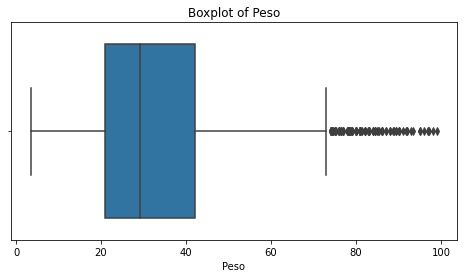

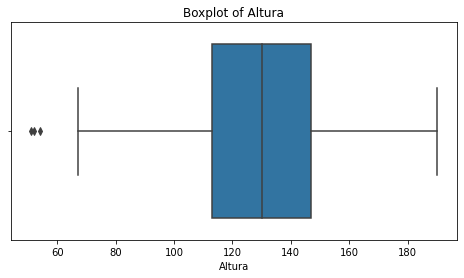

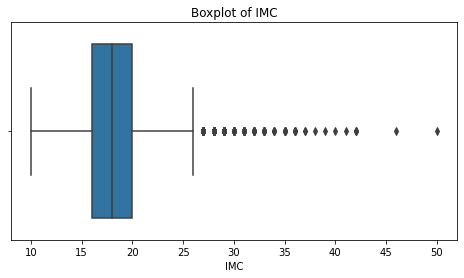

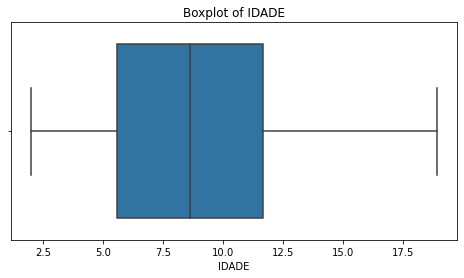

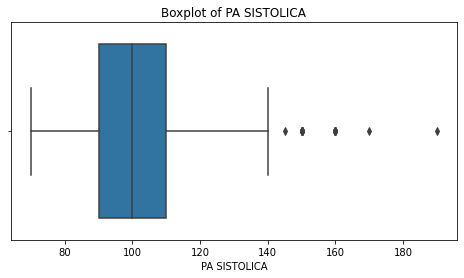

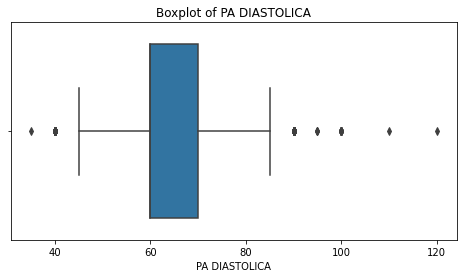

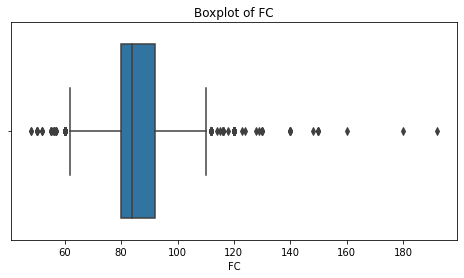

In [25]:
numeric_cols = df.select_dtypes(include='float64').columns
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [26]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [27]:
df_scaled

,Peso,Altura,IMC,IDADE,Convenio,PULSOS,PA SISTOLICA,PA DIASTOLICA,PPA,NORMAL X ANORMAL,B2,SOPRO,FC,HDA 1,SEXO,MOTIVO1,MOTIVO2
4,0.429867,0.547545,0.411976,0.210059,SULAM,NORMAIS,-1.473845,-1.417627,NORMAL,ANORMAL,NORMAL,AUSENTE,0.404801,NaN,M,5__PARECER_CARDIOLOGICO,5__ATIVIDADE_FISICA
5,-0.454748,-0.844930,0.672119,-1.176879,GS,NORMAIS,-0.095101,-0.250424,NORMAL,ANORMAL,DESDOB_FIXO,AUSENTE,1.304559,ASSINTOMATICO,M,2__CHECKUP,NaN
7,-0.323694,-0.612851,0.411976,-0.779468,GS,NORMAIS,0.824061,0.333178,PREHIPERTENSAO_PAS,ANORMAL,NORMAL,AUSENTE,-0.494958,ASSINTOMATICO,F,5__PARECER_CARDIOLOGICO,5__CIRURGIA
10,-0.553038,-0.380771,-0.628594,-0.686116,UR,NORMAIS,-0.095101,0.333178,NORMAL,ANORMAL,NORMAL,SISTOLICO,0.224849,ASSINTOMATICO,M,5__PARECER_CARDIOLOGICO,5__CIRURGIA
16,-1.470416,-1.912494,-1.409022,-1.624966,SA,NORMAIS,-1.014264,-0.250424,NORMAL,NORMAL,NORMAL,AUSENTE,0.854680,ASSINTOMATICO,F,5__PARECER_CARDIOLOGICO,5__CIRURGIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17859,0.174311,0.222635,0.411976,-0.134009,REAL,NORMAIS,-0.095101,-0.250424,NAO_CALCULADO,ANORMAL,NORMAL,AUSENTE,-1.214765,NaN,M,5__PARECER_CARDIOLOGICO,5__CIRURGIA
17861,0.659211,0.361882,1.192404,-0.155346,NaN,NORMAIS,-0.095101,-0.250424,NAO_CALCULADO,ANORMAL,NORMAL,AUSENTE,-0.315006,DISPNEIA,M,5__PARECER_CARDIOLOGICO,NaN
17863,-0.389221,-0.055860,-0.628594,-0.136676,GRUPO,NORMAIS,-0.095101,-0.250424,NAO_CALCULADO,ANORMAL,NORMAL,AUSENTE,NaN,DOR_PRECORDIAL,M,5__PARECER_CARDIOLOGICO,NaN
17865,-0.225403,0.129803,-0.368452,-0.037990,SULA,NORMAIS,-1.014264,-1.417627,NAO_CALCULADO,ANORMAL,NORMAL,AUSENTE,NaN,NaN,F,6__SUSPEITA_DE_CARDIOPATIA,6__DOR_PRECORDIAL


## Univariate Analysis